# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

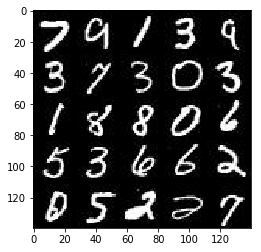

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

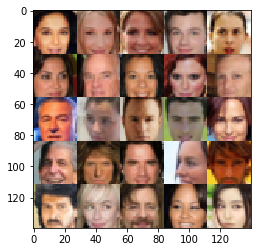

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    # discriminator parameters 
    alpha = 0.1
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        h1 = tf.layers.conv2d(images, 64, 5, 2, 'same')
        h1 = tf.maximum(alpha * h1, h1)
        
        h2 = tf.layers.conv2d(h1, 128, 5, 2, 'same')
        h2 = tf.layers.batch_normalization(h2, training=True)
        h2 = tf.maximum(alpha * h2, h2)
        
        h3 = tf.layers.conv2d(h2, 256, 5, 2, 'same')
        h3 = tf.layers.batch_normalization(h3, training=True)
        h3 = tf.maximum(alpha * h3, h3)
        
        flat = tf.reshape(h3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        
        alpha = 0.1

        h1 = tf.layers.dense(z, 2*2*512)
        h1 = tf.reshape(h1, (-1, 2, 2, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(alpha * h1, h1)

        h2 = tf.layers.conv2d_transpose(h1, 256, 5, 2, 'valid')
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha * h2, h2)

        h3 = tf.layers.conv2d_transpose(h2, 128, 5, 2, 'same')
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(alpha * h3, h3)

        logits = tf.layers.conv2d_transpose(h3, out_channel_dim, 5, 2, 'same')
        out = tf.tanh(logits)

    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.9):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    d_train_opt = tf.train.AdamOptimizer(
        learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(
            learning_rate, beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, img_width, img_height, img_channels = data_shape
    
    real_input, z_input, lr = model_inputs(
        img_width, img_height, img_channels, z_dim)
    
    d_loss, g_loss = model_loss(real_input, z_input, img_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    print_every = 10
    show_every = 100
    losses = []
    n_images = 25
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images *= 2.0
                z_sample = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={
                        real_input: batch_images, z_input: z_sample, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={
                        z_input: z_sample, lr: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({z_input: z_sample, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: z_sample})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, z_input, img_channels, data_image_mode)                        

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0717... Generator Loss: 2.9632
Epoch 1/2... Discriminator Loss: 0.0050... Generator Loss: 5.7728
Epoch 1/2... Discriminator Loss: 1.3315... Generator Loss: 0.3151
Epoch 1/2... Discriminator Loss: 4.9391... Generator Loss: 0.0076
Epoch 1/2... Discriminator Loss: 0.6049... Generator Loss: 17.9748
Epoch 1/2... Discriminator Loss: 1.8820... Generator Loss: 0.2599
Epoch 1/2... Discriminator Loss: 0.4602... Generator Loss: 13.7613
Epoch 1/2... Discriminator Loss: 0.4406... Generator Loss: 2.4960
Epoch 1/2... Discriminator Loss: 0.8835... Generator Loss: 1.0665
Epoch 1/2... Discriminator Loss: 0.1738... Generator Loss: 2.8330


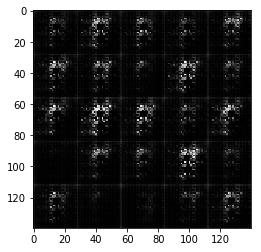

Epoch 1/2... Discriminator Loss: 0.2856... Generator Loss: 4.2612
Epoch 1/2... Discriminator Loss: 0.2363... Generator Loss: 2.1578
Epoch 1/2... Discriminator Loss: 0.1387... Generator Loss: 6.6997
Epoch 1/2... Discriminator Loss: 0.1787... Generator Loss: 2.8837
Epoch 1/2... Discriminator Loss: 0.4451... Generator Loss: 4.0890
Epoch 1/2... Discriminator Loss: 0.1104... Generator Loss: 3.3582
Epoch 1/2... Discriminator Loss: 0.1485... Generator Loss: 3.7986
Epoch 1/2... Discriminator Loss: 0.0489... Generator Loss: 5.5694
Epoch 1/2... Discriminator Loss: 0.2354... Generator Loss: 4.6538
Epoch 1/2... Discriminator Loss: 0.1331... Generator Loss: 3.4621


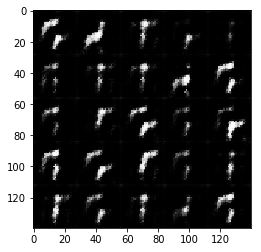

Epoch 1/2... Discriminator Loss: 0.2593... Generator Loss: 3.9735
Epoch 1/2... Discriminator Loss: 0.3024... Generator Loss: 2.0867
Epoch 1/2... Discriminator Loss: 0.0923... Generator Loss: 3.1515
Epoch 1/2... Discriminator Loss: 0.1519... Generator Loss: 2.9959
Epoch 1/2... Discriminator Loss: 0.0887... Generator Loss: 4.8187
Epoch 1/2... Discriminator Loss: 1.8473... Generator Loss: 0.3891
Epoch 1/2... Discriminator Loss: 0.4163... Generator Loss: 2.2303
Epoch 1/2... Discriminator Loss: 0.0741... Generator Loss: 3.9114
Epoch 1/2... Discriminator Loss: 0.2014... Generator Loss: 3.4313
Epoch 1/2... Discriminator Loss: 0.1191... Generator Loss: 4.3129


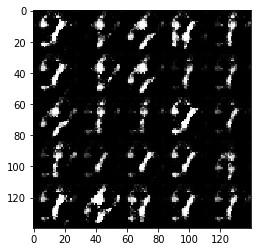

Epoch 1/2... Discriminator Loss: 0.1292... Generator Loss: 3.0328
Epoch 1/2... Discriminator Loss: 0.5316... Generator Loss: 1.5116
Epoch 1/2... Discriminator Loss: 0.6692... Generator Loss: 9.5637
Epoch 1/2... Discriminator Loss: 0.2821... Generator Loss: 2.4596
Epoch 1/2... Discriminator Loss: 1.2438... Generator Loss: 0.7605
Epoch 1/2... Discriminator Loss: 0.2224... Generator Loss: 4.5979
Epoch 1/2... Discriminator Loss: 0.1454... Generator Loss: 3.2916
Epoch 1/2... Discriminator Loss: 0.2038... Generator Loss: 4.0247
Epoch 1/2... Discriminator Loss: 0.1735... Generator Loss: 3.3020
Epoch 1/2... Discriminator Loss: 0.3638... Generator Loss: 2.1062


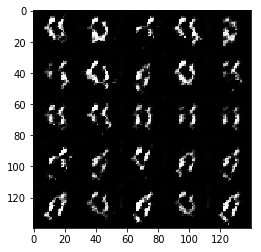

Epoch 1/2... Discriminator Loss: 0.1709... Generator Loss: 3.7016
Epoch 1/2... Discriminator Loss: 1.8054... Generator Loss: 9.5409
Epoch 1/2... Discriminator Loss: 0.3370... Generator Loss: 2.1923
Epoch 1/2... Discriminator Loss: 0.1302... Generator Loss: 3.2189
Epoch 1/2... Discriminator Loss: 0.4507... Generator Loss: 2.0826
Epoch 1/2... Discriminator Loss: 0.3108... Generator Loss: 2.4355
Epoch 1/2... Discriminator Loss: 0.1667... Generator Loss: 3.3361
Epoch 1/2... Discriminator Loss: 0.3502... Generator Loss: 5.5122
Epoch 1/2... Discriminator Loss: 0.6994... Generator Loss: 1.7305
Epoch 1/2... Discriminator Loss: 0.3030... Generator Loss: 2.2831


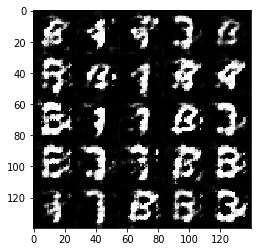

Epoch 1/2... Discriminator Loss: 0.1841... Generator Loss: 3.2280
Epoch 1/2... Discriminator Loss: 0.1569... Generator Loss: 4.1736
Epoch 1/2... Discriminator Loss: 1.1557... Generator Loss: 0.8759
Epoch 1/2... Discriminator Loss: 0.5995... Generator Loss: 1.5192
Epoch 1/2... Discriminator Loss: 0.3424... Generator Loss: 2.7897
Epoch 1/2... Discriminator Loss: 0.4927... Generator Loss: 2.8421
Epoch 1/2... Discriminator Loss: 0.2890... Generator Loss: 2.3129
Epoch 1/2... Discriminator Loss: 1.1194... Generator Loss: 6.1488
Epoch 1/2... Discriminator Loss: 0.4297... Generator Loss: 3.9671
Epoch 1/2... Discriminator Loss: 0.4568... Generator Loss: 2.0075


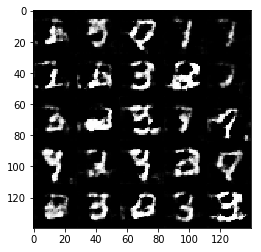

Epoch 1/2... Discriminator Loss: 0.4795... Generator Loss: 3.5193
Epoch 1/2... Discriminator Loss: 0.4150... Generator Loss: 2.4131
Epoch 1/2... Discriminator Loss: 0.9905... Generator Loss: 0.9811
Epoch 1/2... Discriminator Loss: 0.5953... Generator Loss: 2.3338
Epoch 1/2... Discriminator Loss: 0.4249... Generator Loss: 2.3028
Epoch 1/2... Discriminator Loss: 1.2752... Generator Loss: 0.5653
Epoch 1/2... Discriminator Loss: 0.6532... Generator Loss: 2.9151
Epoch 1/2... Discriminator Loss: 0.7648... Generator Loss: 1.2559
Epoch 1/2... Discriminator Loss: 1.2050... Generator Loss: 0.5674
Epoch 1/2... Discriminator Loss: 0.4779... Generator Loss: 1.7354


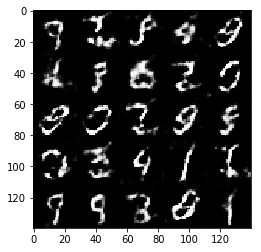

Epoch 1/2... Discriminator Loss: 1.2312... Generator Loss: 0.5739
Epoch 1/2... Discriminator Loss: 0.5390... Generator Loss: 1.5534
Epoch 1/2... Discriminator Loss: 1.1737... Generator Loss: 0.7639
Epoch 1/2... Discriminator Loss: 0.5712... Generator Loss: 1.6197
Epoch 1/2... Discriminator Loss: 0.7241... Generator Loss: 1.3389
Epoch 1/2... Discriminator Loss: 0.4989... Generator Loss: 3.7656
Epoch 1/2... Discriminator Loss: 0.5214... Generator Loss: 2.0136
Epoch 1/2... Discriminator Loss: 0.5360... Generator Loss: 2.5855
Epoch 1/2... Discriminator Loss: 0.4628... Generator Loss: 1.9759
Epoch 1/2... Discriminator Loss: 0.7292... Generator Loss: 1.2575


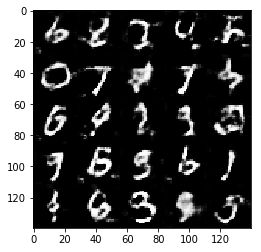

Epoch 1/2... Discriminator Loss: 0.5420... Generator Loss: 2.5308
Epoch 1/2... Discriminator Loss: 0.7742... Generator Loss: 0.9647
Epoch 1/2... Discriminator Loss: 0.5266... Generator Loss: 1.6300
Epoch 1/2... Discriminator Loss: 0.7184... Generator Loss: 1.4491
Epoch 1/2... Discriminator Loss: 1.0770... Generator Loss: 0.7281
Epoch 1/2... Discriminator Loss: 0.8435... Generator Loss: 0.8285
Epoch 1/2... Discriminator Loss: 0.6252... Generator Loss: 1.5154
Epoch 1/2... Discriminator Loss: 0.6000... Generator Loss: 1.6581
Epoch 1/2... Discriminator Loss: 0.7514... Generator Loss: 2.9766
Epoch 1/2... Discriminator Loss: 1.5371... Generator Loss: 0.3865


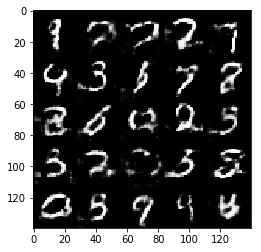

Epoch 1/2... Discriminator Loss: 0.8948... Generator Loss: 2.5507
Epoch 1/2... Discriminator Loss: 0.9917... Generator Loss: 3.2468
Epoch 1/2... Discriminator Loss: 0.6197... Generator Loss: 1.9309
Epoch 2/2... Discriminator Loss: 0.6269... Generator Loss: 2.2829
Epoch 2/2... Discriminator Loss: 1.1895... Generator Loss: 0.6584
Epoch 2/2... Discriminator Loss: 0.7636... Generator Loss: 1.1490
Epoch 2/2... Discriminator Loss: 0.4564... Generator Loss: 1.7550
Epoch 2/2... Discriminator Loss: 0.6983... Generator Loss: 1.2779
Epoch 2/2... Discriminator Loss: 0.9257... Generator Loss: 0.7927
Epoch 2/2... Discriminator Loss: 0.6758... Generator Loss: 1.4205


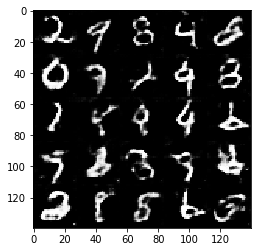

Epoch 2/2... Discriminator Loss: 0.5081... Generator Loss: 1.4227
Epoch 2/2... Discriminator Loss: 0.5739... Generator Loss: 1.3823
Epoch 2/2... Discriminator Loss: 0.6674... Generator Loss: 1.1794
Epoch 2/2... Discriminator Loss: 0.9855... Generator Loss: 0.7410
Epoch 2/2... Discriminator Loss: 0.8002... Generator Loss: 0.9052
Epoch 2/2... Discriminator Loss: 0.9675... Generator Loss: 2.8590
Epoch 2/2... Discriminator Loss: 0.7245... Generator Loss: 1.2928
Epoch 2/2... Discriminator Loss: 0.5778... Generator Loss: 1.4915
Epoch 2/2... Discriminator Loss: 0.8184... Generator Loss: 0.9461
Epoch 2/2... Discriminator Loss: 0.8191... Generator Loss: 2.4405


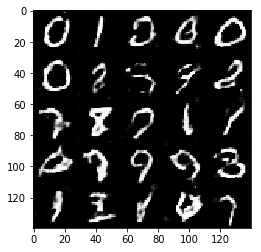

Epoch 2/2... Discriminator Loss: 0.9919... Generator Loss: 1.5329
Epoch 2/2... Discriminator Loss: 0.9114... Generator Loss: 0.6986
Epoch 2/2... Discriminator Loss: 0.7640... Generator Loss: 1.1554
Epoch 2/2... Discriminator Loss: 0.6548... Generator Loss: 2.5426
Epoch 2/2... Discriminator Loss: 0.8465... Generator Loss: 1.0359
Epoch 2/2... Discriminator Loss: 0.5968... Generator Loss: 1.8312
Epoch 2/2... Discriminator Loss: 0.6842... Generator Loss: 1.1369
Epoch 2/2... Discriminator Loss: 0.7599... Generator Loss: 1.1554
Epoch 2/2... Discriminator Loss: 0.7938... Generator Loss: 0.9842
Epoch 2/2... Discriminator Loss: 1.0935... Generator Loss: 2.6874


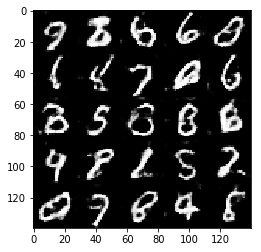

Epoch 2/2... Discriminator Loss: 0.8107... Generator Loss: 1.2862
Epoch 2/2... Discriminator Loss: 0.5910... Generator Loss: 1.3271
Epoch 2/2... Discriminator Loss: 1.3604... Generator Loss: 2.5333
Epoch 2/2... Discriminator Loss: 0.8922... Generator Loss: 1.4478
Epoch 2/2... Discriminator Loss: 0.9562... Generator Loss: 0.7084
Epoch 2/2... Discriminator Loss: 0.6451... Generator Loss: 1.4369
Epoch 2/2... Discriminator Loss: 1.0522... Generator Loss: 2.3380
Epoch 2/2... Discriminator Loss: 1.1435... Generator Loss: 0.5899
Epoch 2/2... Discriminator Loss: 1.4272... Generator Loss: 0.4600
Epoch 2/2... Discriminator Loss: 1.4654... Generator Loss: 0.4233


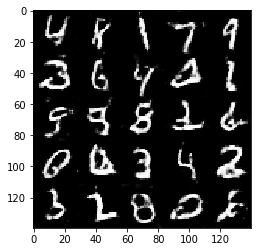

Epoch 2/2... Discriminator Loss: 1.2357... Generator Loss: 0.4609
Epoch 2/2... Discriminator Loss: 0.7251... Generator Loss: 1.2778
Epoch 2/2... Discriminator Loss: 0.9241... Generator Loss: 0.7857
Epoch 2/2... Discriminator Loss: 0.7293... Generator Loss: 1.3818
Epoch 2/2... Discriminator Loss: 0.6157... Generator Loss: 2.0310
Epoch 2/2... Discriminator Loss: 1.1735... Generator Loss: 0.5154
Epoch 2/2... Discriminator Loss: 0.6936... Generator Loss: 1.3906
Epoch 2/2... Discriminator Loss: 1.2497... Generator Loss: 0.5414
Epoch 2/2... Discriminator Loss: 0.8462... Generator Loss: 0.9699
Epoch 2/2... Discriminator Loss: 1.1588... Generator Loss: 0.5829


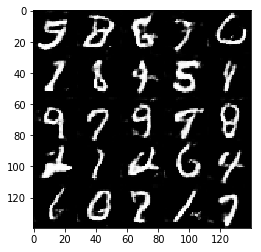

Epoch 2/2... Discriminator Loss: 0.6256... Generator Loss: 1.7325
Epoch 2/2... Discriminator Loss: 0.7548... Generator Loss: 1.1001
Epoch 2/2... Discriminator Loss: 0.8137... Generator Loss: 1.0912
Epoch 2/2... Discriminator Loss: 0.9870... Generator Loss: 0.7057
Epoch 2/2... Discriminator Loss: 0.8588... Generator Loss: 1.5115
Epoch 2/2... Discriminator Loss: 0.6711... Generator Loss: 1.2321
Epoch 2/2... Discriminator Loss: 0.7902... Generator Loss: 1.6880
Epoch 2/2... Discriminator Loss: 0.8887... Generator Loss: 0.9092
Epoch 2/2... Discriminator Loss: 0.8556... Generator Loss: 1.2025
Epoch 2/2... Discriminator Loss: 1.4228... Generator Loss: 0.3585


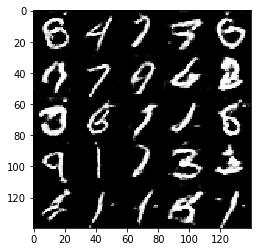

Epoch 2/2... Discriminator Loss: 1.4544... Generator Loss: 0.3843
Epoch 2/2... Discriminator Loss: 0.8487... Generator Loss: 0.9532
Epoch 2/2... Discriminator Loss: 0.7169... Generator Loss: 0.9617
Epoch 2/2... Discriminator Loss: 1.2189... Generator Loss: 0.5359
Epoch 2/2... Discriminator Loss: 0.6665... Generator Loss: 1.1281
Epoch 2/2... Discriminator Loss: 1.5022... Generator Loss: 0.4083
Epoch 2/2... Discriminator Loss: 0.9937... Generator Loss: 0.6227
Epoch 2/2... Discriminator Loss: 0.6878... Generator Loss: 2.6846
Epoch 2/2... Discriminator Loss: 0.6794... Generator Loss: 1.3522
Epoch 2/2... Discriminator Loss: 0.6629... Generator Loss: 1.2829


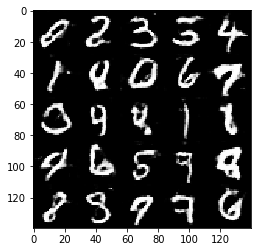

Epoch 2/2... Discriminator Loss: 1.1100... Generator Loss: 0.7234
Epoch 2/2... Discriminator Loss: 1.5399... Generator Loss: 0.3914
Epoch 2/2... Discriminator Loss: 0.6189... Generator Loss: 1.2666
Epoch 2/2... Discriminator Loss: 1.0249... Generator Loss: 0.6456
Epoch 2/2... Discriminator Loss: 1.3195... Generator Loss: 0.4924
Epoch 2/2... Discriminator Loss: 1.2588... Generator Loss: 0.5115
Epoch 2/2... Discriminator Loss: 0.9674... Generator Loss: 0.7000
Epoch 2/2... Discriminator Loss: 0.9929... Generator Loss: 1.3951
Epoch 2/2... Discriminator Loss: 0.9272... Generator Loss: 0.7583
Epoch 2/2... Discriminator Loss: 0.7535... Generator Loss: 1.0973


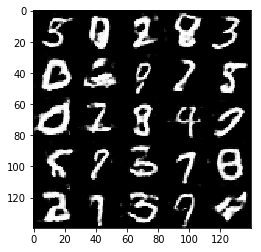

Epoch 2/2... Discriminator Loss: 1.2201... Generator Loss: 0.5089
Epoch 2/2... Discriminator Loss: 0.6926... Generator Loss: 1.1762
Epoch 2/2... Discriminator Loss: 0.8108... Generator Loss: 0.9174
Epoch 2/2... Discriminator Loss: 1.0173... Generator Loss: 0.6350
Epoch 2/2... Discriminator Loss: 0.9414... Generator Loss: 0.7558
Epoch 2/2... Discriminator Loss: 1.3356... Generator Loss: 0.4861
Epoch 2/2... Discriminator Loss: 0.6628... Generator Loss: 1.6996
Epoch 2/2... Discriminator Loss: 0.7985... Generator Loss: 1.0656
Epoch 2/2... Discriminator Loss: 0.7267... Generator Loss: 1.5317
Epoch 2/2... Discriminator Loss: 0.7626... Generator Loss: 1.3786


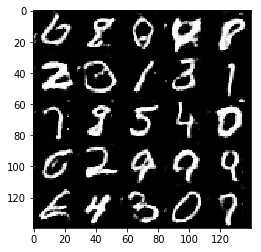

Epoch 2/2... Discriminator Loss: 0.7211... Generator Loss: 1.4694
Epoch 2/2... Discriminator Loss: 0.6659... Generator Loss: 1.1968
Epoch 2/2... Discriminator Loss: 0.9895... Generator Loss: 0.6867
Epoch 2/2... Discriminator Loss: 0.9515... Generator Loss: 0.7371
Epoch 2/2... Discriminator Loss: 1.6483... Generator Loss: 3.9663
Epoch 2/2... Discriminator Loss: 1.4080... Generator Loss: 0.4322
Epoch 2/2... Discriminator Loss: 1.6373... Generator Loss: 0.3334


In [17]:
batch_size = 64
z_dim = 100
learning_rate = 0.0006
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.7321... Generator Loss: 11.0506
Epoch 1/1... Discriminator Loss: 0.3075... Generator Loss: 1.5356
Epoch 1/1... Discriminator Loss: 0.3417... Generator Loss: 17.5469
Epoch 1/1... Discriminator Loss: 0.0403... Generator Loss: 8.8142
Epoch 1/1... Discriminator Loss: 1.3719... Generator Loss: 0.3145
Epoch 1/1... Discriminator Loss: 0.9969... Generator Loss: 0.4904
Epoch 1/1... Discriminator Loss: 0.2212... Generator Loss: 6.7298
Epoch 1/1... Discriminator Loss: 0.1770... Generator Loss: 7.7371
Epoch 1/1... Discriminator Loss: 0.8143... Generator Loss: 4.8530
Epoch 1/1... Discriminator Loss: 0.5093... Generator Loss: 6.2355


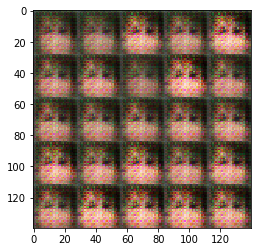

Epoch 1/1... Discriminator Loss: 0.9217... Generator Loss: 1.2236
Epoch 1/1... Discriminator Loss: 0.8167... Generator Loss: 0.8156
Epoch 1/1... Discriminator Loss: 0.3848... Generator Loss: 2.5473
Epoch 1/1... Discriminator Loss: 0.5786... Generator Loss: 2.1689
Epoch 1/1... Discriminator Loss: 0.3096... Generator Loss: 2.0035
Epoch 1/1... Discriminator Loss: 1.4510... Generator Loss: 0.3684
Epoch 1/1... Discriminator Loss: 0.6184... Generator Loss: 1.1681
Epoch 1/1... Discriminator Loss: 0.5953... Generator Loss: 0.9961
Epoch 1/1... Discriminator Loss: 0.6736... Generator Loss: 3.9193
Epoch 1/1... Discriminator Loss: 0.4992... Generator Loss: 3.2648


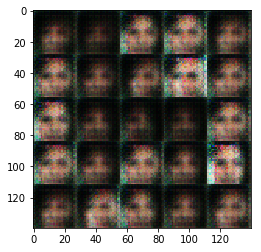

Epoch 1/1... Discriminator Loss: 0.4772... Generator Loss: 2.1657
Epoch 1/1... Discriminator Loss: 0.6576... Generator Loss: 3.3543
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.8494
Epoch 1/1... Discriminator Loss: 1.2560... Generator Loss: 1.6225
Epoch 1/1... Discriminator Loss: 1.0180... Generator Loss: 0.7028
Epoch 1/1... Discriminator Loss: 1.2475... Generator Loss: 4.3927
Epoch 1/1... Discriminator Loss: 0.4469... Generator Loss: 2.1549
Epoch 1/1... Discriminator Loss: 0.6786... Generator Loss: 1.1418
Epoch 1/1... Discriminator Loss: 0.7166... Generator Loss: 1.5284
Epoch 1/1... Discriminator Loss: 0.6951... Generator Loss: 1.9209


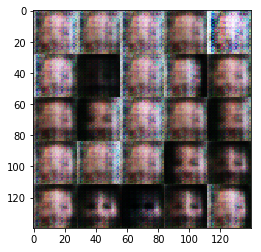

Epoch 1/1... Discriminator Loss: 1.8176... Generator Loss: 0.2496
Epoch 1/1... Discriminator Loss: 1.0538... Generator Loss: 0.8222
Epoch 1/1... Discriminator Loss: 0.7929... Generator Loss: 1.4378
Epoch 1/1... Discriminator Loss: 0.8956... Generator Loss: 1.0896
Epoch 1/1... Discriminator Loss: 0.6484... Generator Loss: 1.5435
Epoch 1/1... Discriminator Loss: 0.5769... Generator Loss: 2.0986
Epoch 1/1... Discriminator Loss: 0.5820... Generator Loss: 1.5765
Epoch 1/1... Discriminator Loss: 0.4706... Generator Loss: 2.0852
Epoch 1/1... Discriminator Loss: 0.7720... Generator Loss: 1.7470
Epoch 1/1... Discriminator Loss: 0.8861... Generator Loss: 2.8915


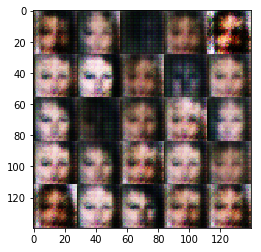

Epoch 1/1... Discriminator Loss: 0.7410... Generator Loss: 1.3342
Epoch 1/1... Discriminator Loss: 1.3194... Generator Loss: 0.5139
Epoch 1/1... Discriminator Loss: 0.6091... Generator Loss: 1.6632
Epoch 1/1... Discriminator Loss: 1.0242... Generator Loss: 1.0330
Epoch 1/1... Discriminator Loss: 0.5585... Generator Loss: 1.6008
Epoch 1/1... Discriminator Loss: 0.8690... Generator Loss: 2.9857
Epoch 1/1... Discriminator Loss: 0.6975... Generator Loss: 1.1171
Epoch 1/1... Discriminator Loss: 0.4317... Generator Loss: 1.6557
Epoch 1/1... Discriminator Loss: 0.6424... Generator Loss: 1.9323
Epoch 1/1... Discriminator Loss: 0.4743... Generator Loss: 1.7292


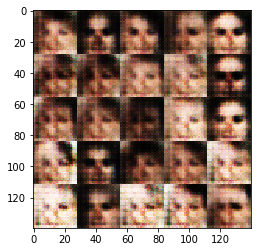

Epoch 1/1... Discriminator Loss: 1.2490... Generator Loss: 0.7284
Epoch 1/1... Discriminator Loss: 0.5825... Generator Loss: 1.9009
Epoch 1/1... Discriminator Loss: 0.9852... Generator Loss: 0.8413
Epoch 1/1... Discriminator Loss: 0.7085... Generator Loss: 2.1573
Epoch 1/1... Discriminator Loss: 0.9615... Generator Loss: 1.2002
Epoch 1/1... Discriminator Loss: 0.8977... Generator Loss: 1.4116
Epoch 1/1... Discriminator Loss: 0.7232... Generator Loss: 2.2288
Epoch 1/1... Discriminator Loss: 0.6240... Generator Loss: 1.9342
Epoch 1/1... Discriminator Loss: 0.8857... Generator Loss: 2.7151
Epoch 1/1... Discriminator Loss: 0.7668... Generator Loss: 4.0541


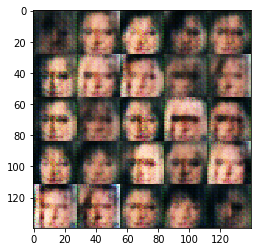

Epoch 1/1... Discriminator Loss: 1.4825... Generator Loss: 4.1808
Epoch 1/1... Discriminator Loss: 0.5415... Generator Loss: 1.6516
Epoch 1/1... Discriminator Loss: 0.5182... Generator Loss: 1.8780
Epoch 1/1... Discriminator Loss: 0.9907... Generator Loss: 0.8920
Epoch 1/1... Discriminator Loss: 0.5872... Generator Loss: 1.5378
Epoch 1/1... Discriminator Loss: 0.7250... Generator Loss: 2.3762
Epoch 1/1... Discriminator Loss: 0.4998... Generator Loss: 2.0414
Epoch 1/1... Discriminator Loss: 0.7508... Generator Loss: 1.1600
Epoch 1/1... Discriminator Loss: 0.9353... Generator Loss: 0.8554
Epoch 1/1... Discriminator Loss: 0.5219... Generator Loss: 1.6781


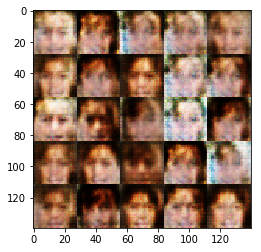

Epoch 1/1... Discriminator Loss: 0.9453... Generator Loss: 0.9629
Epoch 1/1... Discriminator Loss: 0.6161... Generator Loss: 2.4540
Epoch 1/1... Discriminator Loss: 0.7103... Generator Loss: 0.8702
Epoch 1/1... Discriminator Loss: 1.0058... Generator Loss: 3.3255
Epoch 1/1... Discriminator Loss: 0.8219... Generator Loss: 1.4852
Epoch 1/1... Discriminator Loss: 0.7653... Generator Loss: 1.2056
Epoch 1/1... Discriminator Loss: 0.6925... Generator Loss: 1.3765
Epoch 1/1... Discriminator Loss: 0.5785... Generator Loss: 1.9612
Epoch 1/1... Discriminator Loss: 0.5942... Generator Loss: 2.6343
Epoch 1/1... Discriminator Loss: 0.4782... Generator Loss: 2.0593


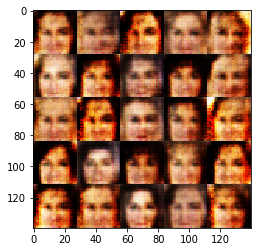

Epoch 1/1... Discriminator Loss: 0.9684... Generator Loss: 0.9736
Epoch 1/1... Discriminator Loss: 0.7409... Generator Loss: 1.4620
Epoch 1/1... Discriminator Loss: 1.0702... Generator Loss: 0.9007
Epoch 1/1... Discriminator Loss: 0.7568... Generator Loss: 2.4818
Epoch 1/1... Discriminator Loss: 0.8260... Generator Loss: 2.8545
Epoch 1/1... Discriminator Loss: 0.5839... Generator Loss: 1.9780
Epoch 1/1... Discriminator Loss: 0.8752... Generator Loss: 1.0848
Epoch 1/1... Discriminator Loss: 0.5895... Generator Loss: 2.9163
Epoch 1/1... Discriminator Loss: 0.5812... Generator Loss: 1.2765
Epoch 1/1... Discriminator Loss: 0.4894... Generator Loss: 2.2416


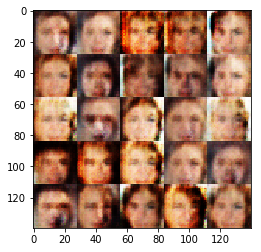

Epoch 1/1... Discriminator Loss: 1.1047... Generator Loss: 0.5552
Epoch 1/1... Discriminator Loss: 0.7636... Generator Loss: 1.5891
Epoch 1/1... Discriminator Loss: 0.7831... Generator Loss: 1.7856
Epoch 1/1... Discriminator Loss: 1.1343... Generator Loss: 0.6508
Epoch 1/1... Discriminator Loss: 1.0698... Generator Loss: 0.7460
Epoch 1/1... Discriminator Loss: 0.9214... Generator Loss: 0.7869
Epoch 1/1... Discriminator Loss: 1.0112... Generator Loss: 0.7537
Epoch 1/1... Discriminator Loss: 0.7820... Generator Loss: 0.9872
Epoch 1/1... Discriminator Loss: 0.9966... Generator Loss: 3.1612
Epoch 1/1... Discriminator Loss: 0.5905... Generator Loss: 1.5639


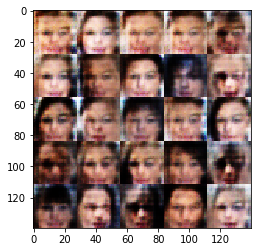

Epoch 1/1... Discriminator Loss: 0.6687... Generator Loss: 3.4286
Epoch 1/1... Discriminator Loss: 0.6286... Generator Loss: 1.7519
Epoch 1/1... Discriminator Loss: 2.0134... Generator Loss: 3.4115
Epoch 1/1... Discriminator Loss: 0.7939... Generator Loss: 1.2669
Epoch 1/1... Discriminator Loss: 0.8191... Generator Loss: 1.0887
Epoch 1/1... Discriminator Loss: 0.7597... Generator Loss: 2.3057
Epoch 1/1... Discriminator Loss: 1.0161... Generator Loss: 1.2154
Epoch 1/1... Discriminator Loss: 1.1401... Generator Loss: 0.6510
Epoch 1/1... Discriminator Loss: 0.6628... Generator Loss: 1.8174
Epoch 1/1... Discriminator Loss: 0.4645... Generator Loss: 1.8700


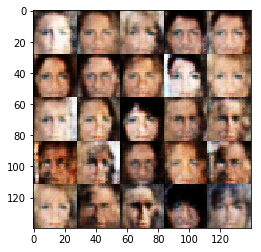

Epoch 1/1... Discriminator Loss: 0.7064... Generator Loss: 1.5216
Epoch 1/1... Discriminator Loss: 0.5906... Generator Loss: 2.0693
Epoch 1/1... Discriminator Loss: 0.7766... Generator Loss: 2.4999
Epoch 1/1... Discriminator Loss: 0.9564... Generator Loss: 2.8733
Epoch 1/1... Discriminator Loss: 0.7591... Generator Loss: 1.0692
Epoch 1/1... Discriminator Loss: 0.6186... Generator Loss: 1.7782
Epoch 1/1... Discriminator Loss: 0.4798... Generator Loss: 2.1490
Epoch 1/1... Discriminator Loss: 0.7808... Generator Loss: 1.2246
Epoch 1/1... Discriminator Loss: 0.8911... Generator Loss: 1.0399
Epoch 1/1... Discriminator Loss: 0.7846... Generator Loss: 0.9180


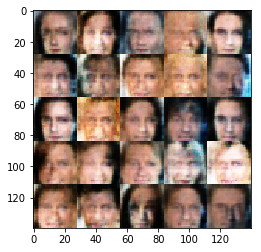

Epoch 1/1... Discriminator Loss: 1.0199... Generator Loss: 0.6675
Epoch 1/1... Discriminator Loss: 0.4430... Generator Loss: 1.9996
Epoch 1/1... Discriminator Loss: 0.9627... Generator Loss: 1.7705
Epoch 1/1... Discriminator Loss: 0.8449... Generator Loss: 1.1876
Epoch 1/1... Discriminator Loss: 0.8341... Generator Loss: 2.4016
Epoch 1/1... Discriminator Loss: 0.7061... Generator Loss: 1.2402
Epoch 1/1... Discriminator Loss: 0.7886... Generator Loss: 1.5385
Epoch 1/1... Discriminator Loss: 0.9679... Generator Loss: 0.7457
Epoch 1/1... Discriminator Loss: 0.6977... Generator Loss: 2.3497
Epoch 1/1... Discriminator Loss: 0.7486... Generator Loss: 1.3119


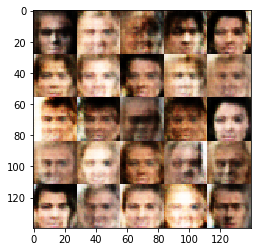

Epoch 1/1... Discriminator Loss: 0.7351... Generator Loss: 1.6153
Epoch 1/1... Discriminator Loss: 0.5333... Generator Loss: 2.3905
Epoch 1/1... Discriminator Loss: 1.0280... Generator Loss: 2.0767
Epoch 1/1... Discriminator Loss: 0.5475... Generator Loss: 1.5213
Epoch 1/1... Discriminator Loss: 1.0788... Generator Loss: 0.7475
Epoch 1/1... Discriminator Loss: 1.0832... Generator Loss: 0.6771
Epoch 1/1... Discriminator Loss: 1.0841... Generator Loss: 0.6917
Epoch 1/1... Discriminator Loss: 0.6509... Generator Loss: 1.4475
Epoch 1/1... Discriminator Loss: 0.7026... Generator Loss: 1.3834
Epoch 1/1... Discriminator Loss: 1.5678... Generator Loss: 0.3022


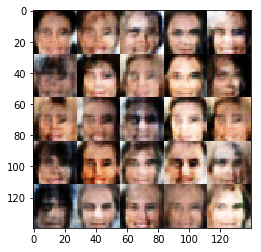

Epoch 1/1... Discriminator Loss: 0.8288... Generator Loss: 2.6040
Epoch 1/1... Discriminator Loss: 0.9662... Generator Loss: 3.2126
Epoch 1/1... Discriminator Loss: 0.6445... Generator Loss: 1.1129
Epoch 1/1... Discriminator Loss: 0.9190... Generator Loss: 1.6949
Epoch 1/1... Discriminator Loss: 0.8385... Generator Loss: 3.5748
Epoch 1/1... Discriminator Loss: 0.9526... Generator Loss: 0.7743
Epoch 1/1... Discriminator Loss: 0.5145... Generator Loss: 1.5427
Epoch 1/1... Discriminator Loss: 0.8486... Generator Loss: 2.5204
Epoch 1/1... Discriminator Loss: 0.9130... Generator Loss: 0.8528
Epoch 1/1... Discriminator Loss: 1.8302... Generator Loss: 0.2367


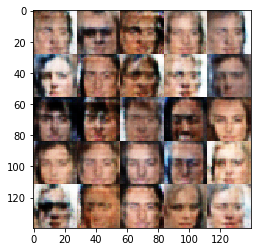

Epoch 1/1... Discriminator Loss: 0.7453... Generator Loss: 2.7573
Epoch 1/1... Discriminator Loss: 1.0605... Generator Loss: 0.5994
Epoch 1/1... Discriminator Loss: 0.6733... Generator Loss: 1.5114
Epoch 1/1... Discriminator Loss: 0.8652... Generator Loss: 0.9776
Epoch 1/1... Discriminator Loss: 0.6074... Generator Loss: 1.6902
Epoch 1/1... Discriminator Loss: 0.8183... Generator Loss: 1.0335
Epoch 1/1... Discriminator Loss: 0.7392... Generator Loss: 1.0571
Epoch 1/1... Discriminator Loss: 0.8613... Generator Loss: 1.2362
Epoch 1/1... Discriminator Loss: 0.5540... Generator Loss: 1.6950
Epoch 1/1... Discriminator Loss: 0.5220... Generator Loss: 2.4993


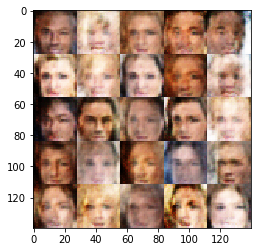

Epoch 1/1... Discriminator Loss: 1.1507... Generator Loss: 0.5452
Epoch 1/1... Discriminator Loss: 1.0450... Generator Loss: 0.6749
Epoch 1/1... Discriminator Loss: 1.5453... Generator Loss: 0.3887
Epoch 1/1... Discriminator Loss: 0.6197... Generator Loss: 1.9030
Epoch 1/1... Discriminator Loss: 0.8291... Generator Loss: 1.2963
Epoch 1/1... Discriminator Loss: 1.2614... Generator Loss: 0.5270
Epoch 1/1... Discriminator Loss: 0.6445... Generator Loss: 1.8135
Epoch 1/1... Discriminator Loss: 1.2697... Generator Loss: 2.9084
Epoch 1/1... Discriminator Loss: 0.6734... Generator Loss: 1.6387
Epoch 1/1... Discriminator Loss: 0.6955... Generator Loss: 1.2282


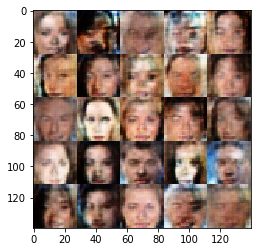

Epoch 1/1... Discriminator Loss: 0.7798... Generator Loss: 0.9571
Epoch 1/1... Discriminator Loss: 0.8445... Generator Loss: 1.5065
Epoch 1/1... Discriminator Loss: 0.5870... Generator Loss: 1.6245
Epoch 1/1... Discriminator Loss: 1.0863... Generator Loss: 0.6178
Epoch 1/1... Discriminator Loss: 0.4911... Generator Loss: 1.4259
Epoch 1/1... Discriminator Loss: 1.6121... Generator Loss: 0.3107
Epoch 1/1... Discriminator Loss: 1.1741... Generator Loss: 1.3450
Epoch 1/1... Discriminator Loss: 0.7509... Generator Loss: 1.6864
Epoch 1/1... Discriminator Loss: 0.9578... Generator Loss: 0.9113
Epoch 1/1... Discriminator Loss: 0.5289... Generator Loss: 1.9409


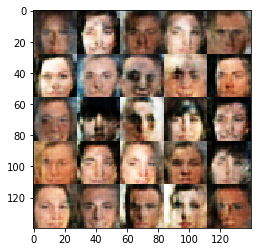

Epoch 1/1... Discriminator Loss: 0.8752... Generator Loss: 1.2692
Epoch 1/1... Discriminator Loss: 0.5301... Generator Loss: 1.7394
Epoch 1/1... Discriminator Loss: 0.9551... Generator Loss: 0.9028
Epoch 1/1... Discriminator Loss: 0.5490... Generator Loss: 2.5346
Epoch 1/1... Discriminator Loss: 0.6677... Generator Loss: 1.4989
Epoch 1/1... Discriminator Loss: 1.0916... Generator Loss: 0.6172
Epoch 1/1... Discriminator Loss: 0.6944... Generator Loss: 2.1415
Epoch 1/1... Discriminator Loss: 0.8159... Generator Loss: 1.1980
Epoch 1/1... Discriminator Loss: 0.5603... Generator Loss: 2.4008
Epoch 1/1... Discriminator Loss: 0.5448... Generator Loss: 1.9744


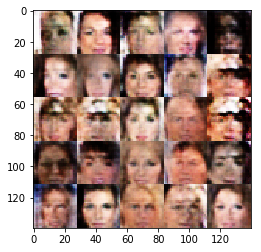

Epoch 1/1... Discriminator Loss: 1.1786... Generator Loss: 0.5393
Epoch 1/1... Discriminator Loss: 0.8424... Generator Loss: 0.9726
Epoch 1/1... Discriminator Loss: 1.3322... Generator Loss: 0.4887
Epoch 1/1... Discriminator Loss: 0.7620... Generator Loss: 1.3764
Epoch 1/1... Discriminator Loss: 0.7248... Generator Loss: 0.9680
Epoch 1/1... Discriminator Loss: 0.7769... Generator Loss: 1.1612
Epoch 1/1... Discriminator Loss: 0.7559... Generator Loss: 1.3594
Epoch 1/1... Discriminator Loss: 1.2759... Generator Loss: 2.4873
Epoch 1/1... Discriminator Loss: 0.8432... Generator Loss: 1.9623
Epoch 1/1... Discriminator Loss: 0.8424... Generator Loss: 1.1589


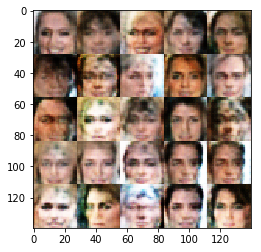

Epoch 1/1... Discriminator Loss: 0.8494... Generator Loss: 1.4835
Epoch 1/1... Discriminator Loss: 1.0374... Generator Loss: 0.8028
Epoch 1/1... Discriminator Loss: 0.7651... Generator Loss: 2.0100
Epoch 1/1... Discriminator Loss: 1.1620... Generator Loss: 3.0282
Epoch 1/1... Discriminator Loss: 0.9355... Generator Loss: 1.1380
Epoch 1/1... Discriminator Loss: 0.9801... Generator Loss: 1.0396
Epoch 1/1... Discriminator Loss: 0.8245... Generator Loss: 1.0322
Epoch 1/1... Discriminator Loss: 0.8492... Generator Loss: 2.1250
Epoch 1/1... Discriminator Loss: 0.7628... Generator Loss: 1.2597
Epoch 1/1... Discriminator Loss: 1.0543... Generator Loss: 1.5789


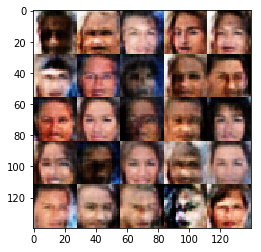

Epoch 1/1... Discriminator Loss: 0.7030... Generator Loss: 1.1236
Epoch 1/1... Discriminator Loss: 1.7717... Generator Loss: 4.3391
Epoch 1/1... Discriminator Loss: 0.6894... Generator Loss: 1.2933
Epoch 1/1... Discriminator Loss: 0.7805... Generator Loss: 1.4819
Epoch 1/1... Discriminator Loss: 0.7224... Generator Loss: 1.4963
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.3942
Epoch 1/1... Discriminator Loss: 0.6974... Generator Loss: 1.3912
Epoch 1/1... Discriminator Loss: 1.0403... Generator Loss: 0.7890
Epoch 1/1... Discriminator Loss: 1.5946... Generator Loss: 2.9025
Epoch 1/1... Discriminator Loss: 1.0658... Generator Loss: 1.9744


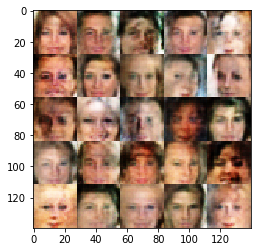

Epoch 1/1... Discriminator Loss: 0.8397... Generator Loss: 1.1320
Epoch 1/1... Discriminator Loss: 0.5565... Generator Loss: 1.6739
Epoch 1/1... Discriminator Loss: 0.7229... Generator Loss: 1.4577
Epoch 1/1... Discriminator Loss: 0.6351... Generator Loss: 1.3286
Epoch 1/1... Discriminator Loss: 0.9174... Generator Loss: 0.8452
Epoch 1/1... Discriminator Loss: 0.5697... Generator Loss: 1.7869
Epoch 1/1... Discriminator Loss: 0.8287... Generator Loss: 0.9717
Epoch 1/1... Discriminator Loss: 0.9616... Generator Loss: 0.7666
Epoch 1/1... Discriminator Loss: 0.6339... Generator Loss: 1.3798
Epoch 1/1... Discriminator Loss: 0.7363... Generator Loss: 1.0798


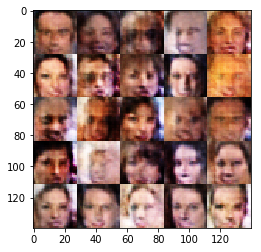

Epoch 1/1... Discriminator Loss: 0.7792... Generator Loss: 0.8944
Epoch 1/1... Discriminator Loss: 0.7630... Generator Loss: 1.7544
Epoch 1/1... Discriminator Loss: 1.2810... Generator Loss: 2.9009
Epoch 1/1... Discriminator Loss: 0.8896... Generator Loss: 0.9873
Epoch 1/1... Discriminator Loss: 0.8544... Generator Loss: 1.4922
Epoch 1/1... Discriminator Loss: 0.9422... Generator Loss: 0.9619
Epoch 1/1... Discriminator Loss: 0.8225... Generator Loss: 1.1506
Epoch 1/1... Discriminator Loss: 0.7774... Generator Loss: 1.3286
Epoch 1/1... Discriminator Loss: 0.6974... Generator Loss: 1.4488
Epoch 1/1... Discriminator Loss: 0.6811... Generator Loss: 1.2185


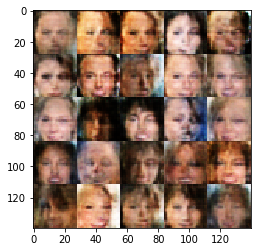

Epoch 1/1... Discriminator Loss: 0.6884... Generator Loss: 1.8578
Epoch 1/1... Discriminator Loss: 0.8971... Generator Loss: 2.1131
Epoch 1/1... Discriminator Loss: 0.9871... Generator Loss: 0.8108
Epoch 1/1... Discriminator Loss: 1.0130... Generator Loss: 0.6680
Epoch 1/1... Discriminator Loss: 0.6487... Generator Loss: 1.6750
Epoch 1/1... Discriminator Loss: 0.6314... Generator Loss: 1.8089
Epoch 1/1... Discriminator Loss: 1.0960... Generator Loss: 0.6973
Epoch 1/1... Discriminator Loss: 1.1843... Generator Loss: 0.5527
Epoch 1/1... Discriminator Loss: 0.7665... Generator Loss: 1.0201
Epoch 1/1... Discriminator Loss: 0.8436... Generator Loss: 2.6630


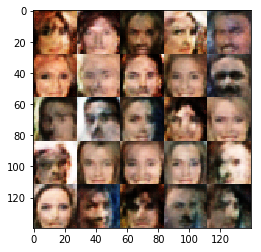

Epoch 1/1... Discriminator Loss: 0.7115... Generator Loss: 1.1798
Epoch 1/1... Discriminator Loss: 0.9864... Generator Loss: 0.7399
Epoch 1/1... Discriminator Loss: 0.7514... Generator Loss: 1.2686
Epoch 1/1... Discriminator Loss: 0.6415... Generator Loss: 1.1758
Epoch 1/1... Discriminator Loss: 0.8076... Generator Loss: 1.5294
Epoch 1/1... Discriminator Loss: 1.0947... Generator Loss: 0.6973
Epoch 1/1... Discriminator Loss: 1.1140... Generator Loss: 2.5641
Epoch 1/1... Discriminator Loss: 0.6097... Generator Loss: 1.5172
Epoch 1/1... Discriminator Loss: 1.1432... Generator Loss: 0.5692
Epoch 1/1... Discriminator Loss: 0.6315... Generator Loss: 1.7223


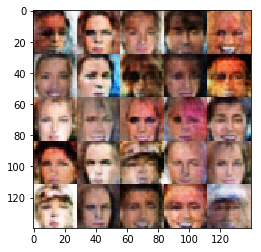

Epoch 1/1... Discriminator Loss: 0.7620... Generator Loss: 1.8225
Epoch 1/1... Discriminator Loss: 0.7738... Generator Loss: 1.6392
Epoch 1/1... Discriminator Loss: 0.9139... Generator Loss: 1.0955
Epoch 1/1... Discriminator Loss: 0.8090... Generator Loss: 1.7993
Epoch 1/1... Discriminator Loss: 0.5180... Generator Loss: 1.8337
Epoch 1/1... Discriminator Loss: 0.7830... Generator Loss: 1.7432
Epoch 1/1... Discriminator Loss: 0.8809... Generator Loss: 1.9473
Epoch 1/1... Discriminator Loss: 1.0384... Generator Loss: 0.7115
Epoch 1/1... Discriminator Loss: 0.7249... Generator Loss: 1.1484
Epoch 1/1... Discriminator Loss: 0.8948... Generator Loss: 2.2580


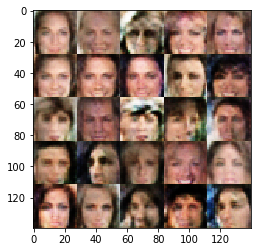

Epoch 1/1... Discriminator Loss: 0.5084... Generator Loss: 1.3040
Epoch 1/1... Discriminator Loss: 0.7000... Generator Loss: 1.0760
Epoch 1/1... Discriminator Loss: 1.1442... Generator Loss: 0.5913
Epoch 1/1... Discriminator Loss: 0.8272... Generator Loss: 0.9867
Epoch 1/1... Discriminator Loss: 0.7592... Generator Loss: 1.2364
Epoch 1/1... Discriminator Loss: 1.0071... Generator Loss: 0.9060
Epoch 1/1... Discriminator Loss: 0.9423... Generator Loss: 0.7172
Epoch 1/1... Discriminator Loss: 1.0916... Generator Loss: 2.5955
Epoch 1/1... Discriminator Loss: 0.6916... Generator Loss: 1.1791
Epoch 1/1... Discriminator Loss: 0.9230... Generator Loss: 2.1428


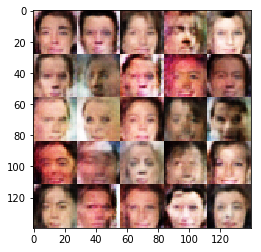

Epoch 1/1... Discriminator Loss: 1.1366... Generator Loss: 1.2325
Epoch 1/1... Discriminator Loss: 0.7680... Generator Loss: 2.2402
Epoch 1/1... Discriminator Loss: 0.8295... Generator Loss: 0.9875
Epoch 1/1... Discriminator Loss: 0.7071... Generator Loss: 1.2809
Epoch 1/1... Discriminator Loss: 1.1818... Generator Loss: 0.5131
Epoch 1/1... Discriminator Loss: 0.9679... Generator Loss: 0.7300
Epoch 1/1... Discriminator Loss: 1.2912... Generator Loss: 0.4703
Epoch 1/1... Discriminator Loss: 1.0323... Generator Loss: 1.1760
Epoch 1/1... Discriminator Loss: 0.8907... Generator Loss: 0.7972
Epoch 1/1... Discriminator Loss: 0.7813... Generator Loss: 1.1798


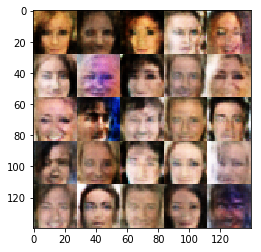

Epoch 1/1... Discriminator Loss: 0.7948... Generator Loss: 1.1210
Epoch 1/1... Discriminator Loss: 1.1871... Generator Loss: 0.5659
Epoch 1/1... Discriminator Loss: 0.8101... Generator Loss: 1.5411
Epoch 1/1... Discriminator Loss: 0.7790... Generator Loss: 1.3475
Epoch 1/1... Discriminator Loss: 0.4513... Generator Loss: 2.7164
Epoch 1/1... Discriminator Loss: 1.0066... Generator Loss: 0.7053
Epoch 1/1... Discriminator Loss: 0.5723... Generator Loss: 1.9471
Epoch 1/1... Discriminator Loss: 0.9471... Generator Loss: 0.8346
Epoch 1/1... Discriminator Loss: 0.7170... Generator Loss: 1.0928
Epoch 1/1... Discriminator Loss: 0.7709... Generator Loss: 1.0024


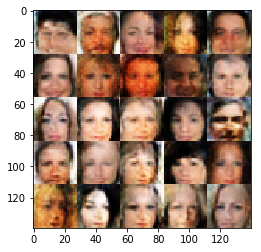

Epoch 1/1... Discriminator Loss: 0.6978... Generator Loss: 1.1749
Epoch 1/1... Discriminator Loss: 0.6429... Generator Loss: 1.3241
Epoch 1/1... Discriminator Loss: 0.8858... Generator Loss: 2.1093
Epoch 1/1... Discriminator Loss: 0.7901... Generator Loss: 2.4118
Epoch 1/1... Discriminator Loss: 1.1118... Generator Loss: 0.6270
Epoch 1/1... Discriminator Loss: 0.7711... Generator Loss: 1.4080
Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 0.4169
Epoch 1/1... Discriminator Loss: 0.9543... Generator Loss: 0.7600
Epoch 1/1... Discriminator Loss: 0.7147... Generator Loss: 1.1782
Epoch 1/1... Discriminator Loss: 0.8100... Generator Loss: 2.0240


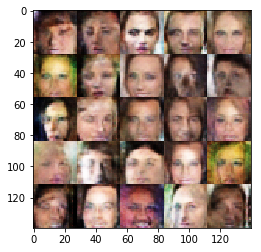

Epoch 1/1... Discriminator Loss: 1.2253... Generator Loss: 0.5477
Epoch 1/1... Discriminator Loss: 0.9288... Generator Loss: 1.9976
Epoch 1/1... Discriminator Loss: 1.0423... Generator Loss: 0.8840
Epoch 1/1... Discriminator Loss: 0.5111... Generator Loss: 1.3623
Epoch 1/1... Discriminator Loss: 0.7595... Generator Loss: 1.4902
Epoch 1/1... Discriminator Loss: 0.9448... Generator Loss: 0.7772


In [18]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.